In [1]:
import tensorflow as tf
import numpy as np
import pickle
import itertools

from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
def get_model(shape):
    model = Sequential()
    model.add(LSTM(150, return_sequences=True, input_shape=shape))
    model.add(Dropout(0.2))
    model.add(LSTM(150, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(shape[1]))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    
    return model

def train_model(model, X, y, val_data, epochs=11, batch_size=50):
    history = model.fit(X, y, validation_data=val_data, epochs=epochs, batch_size=batch_size)
    return history
    
def save(model, name):
    model_json = model.to_json()
    with open(name + '.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(name + '.h5')

def load(name):
    # load json and create model
    json_file = open(name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(name + ".h5")
    return model

In [3]:
def get_sonnets(filename):
    """ Returns entire txt file as string. """
    str = ""
    with open(filename) as file:
        for line in file:
            line = line.strip()
            if line.isdigit() == False and len(line) > 0:
                str += line.lower() + "\n"
    return str

In [4]:
file = 'data/shakespeare.txt'
sons = get_sonnets(file)

print ("# chars in txt: " + str(len(sons)))

# chars in txt: 93674


In [5]:
chars = set(sons) # get set of all characters
print(chars)
print ("# unique chars: " + str(len(chars)))

# create mapping of characters to unique ids
dic_char_to_id = dict((c, i) for i, c in enumerate(chars))
dic_id_to_char = dict((i, c) for i, c in enumerate(chars))

{'i', 'g', ')', 'q', 'a', 'n', 'w', 'p', 'b', 'j', 'y', ':', 'd', 'r', 'k', '\n', ',', '.', ' ', '?', ';', 't', "'", 'h', 's', 'v', 'u', '(', 'e', 'l', 'c', '-', 'o', 'z', 'x', '!', 'f', 'm'}
# unique chars: 38


In [6]:
# create input, output sequences

leng = 40
step_size = 2
seqs, nxt_char = [], []
# take all possible subsequences of 40 consecutive characters
for i in range(0, len(sons) - leng, step_size):
    seqs.append(sons[i: i + leng])
    nxt_char.append(sons[i + leng])
print("# seqs: ", len(seqs))

# seqs:  46817


In [7]:
# convert seqs to one-hot encoding
X = np.zeros((len(seqs), leng, len(chars)), dtype=np.bool)
y = np.zeros((len(seqs), len(chars)), dtype=np.bool)

for i, seq in enumerate(seqs):
    for j, char in enumerate(seq):
        X[i, j, dic_char_to_id[char]] = 1
    y[i, dic_char_to_id[nxt_char[i]]] = 1

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
model = get_model((leng, len(chars)))

In [10]:
history = train_model(model, x_train, y_train, (x_test, y_test))

Train on 31367 samples, validate on 15450 samples
Epoch 1/11
31367/31367 [==============================] - 346s 11ms/step - loss: 2.7882 - val_loss: 2.4198
Epoch 2/11
31367/31367 [==============================] - 314s 10ms/step - loss: 2.2904 - val_loss: 2.1495
Epoch 3/11
31367/31367 [==============================] - 327s 10ms/step - loss: 2.1031 - val_loss: 2.0332
Epoch 4/11
31367/31367 [==============================] - 318s 10ms/step - loss: 1.9922 - val_loss: 1.9479
Epoch 5/11
31367/31367 [==============================] - 774s 25ms/step - loss: 1.9102 - val_loss: 1.8971
Epoch 6/11
31367/31367 [==============================] - 178s 6ms/step - loss: 1.8443 - val_loss: 1.8601
Epoch 7/11
31367/31367 [==============================] - 227s 7ms/step - loss: 1.7891 - val_loss: 1.8186
Epoch 8/11
31367/31367 [==============================] - 257s 8ms/step - loss: 1.7403 - val_loss: 1.8000
Epoch 9/11
31367/31367 [==============================] - 252s 8ms/step - loss: 1.6957 - val_loss

In [11]:
save(model, 'models/Shakespeare_150units_11_50')

#150 units, 200 units, epochs, batch_size, dropout

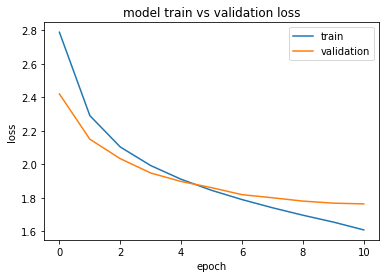

In [17]:
from matplotlib import pyplot
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.savefig('visuals/Shakespeare_150units_11_50_loss.png')
pyplot.show()

In [13]:
min(history.history['val_loss']) #1.7517004969822165

1.7632395873949365

In [14]:
history.history['val_loss'].index(min(history.history['val_loss'])) #11

10

In [15]:
def sample(preds, temperature = 1.0):
    ''' Helper function to sample an index from
    a probability array. Taken from StackOverflow/
    open source code on GitHub. '''

    preds = np.asarray(preds).astype('float')
    preds = np.log(preds) / temperature
    preds[preds == np.inf] = 0

    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return np.argmax(np.random.multinomial(1, preds, 1))

In [18]:
nchar = 800 # length of each line produced from preds
for temp in [1.5, 0.75, 0.25]:
    print( '\n' + '\n' + 'temperature = ' + str(temp) + '\n')
    
    line = 'shall i compare thee to a summer\'s day?\n'
    sentence = line
    
    for i in range(nchar):
        x = np.zeros((1, leng, len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, dic_char_to_id[char]] = 1

        preds = model.predict(x, verbose=False)[0]
        nxt_char = dic_id_to_char[sample(preds, temp)]

        line += nxt_char
        sentence = sentence[1:] + nxt_char
        
    print(line)



temperature = 1.5

shall i compare thee to a summer's day?
ut firmy pouy thou lo,n, thy s e-famb oo shacl,
the glavowh ligst shal chongingers wuwherozt,
nerpefdiulseroardath betmay chiph in my ris:
so if thacet  sroin in me, by your kourvenedh,
i have in xwerby mi-hid, rurbeurin ghil gaash.
shaltit stoy sapplsion fuwli? tlelse
ibhthance ownlo, then thy,iind werine ofs,,
andir putrtiper by divtiesiugblem'sgoange
noh feirdes yerest now i coptaly reud,
by risd i  as trrassururtoif brong aplabp.
evile filauness alge thy self, or sil,o!
yet yis vorn tu ant all psyilve in rie'm,
there' doerer sale cownar in hewderys lighsuenst fhowg:
andy ruyaw i way pay mones,
whacknt ap to, olf aucky nag notee
digilllen fteer irplost frimmongh,
whild at my frames', orenouinad b ot min's,
ay in thosg ild may hath hoursh, cormturead qratibe,.
thinen i abmathy ecfolade, 


temperature = 0.75

shall i compare thee to a summer's day?
nor canser from to their sweet self,
which is no the rebrack that at that  h